In [1]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)
from torchvision.models import resnet18
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = resnet18(num_classes=2).to(device).eval()
model.load_state_dict(torch.load('small_gaussian_label.pkl'))

<All keys matched successfully>

In [8]:
rgb_img = cv2.imread('./noiseImageLabel1.png', 1)[:, :, ::-1]
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]).to(device)
print('model prediction vector is:', model(input_tensor))
print('predict result',model(input_tensor).argmax(1))

model prediction vector is: tensor([[-21.6536,  18.6767]], device='cuda:0', grad_fn=<AddmmBackward0>)
predict result tensor([1], device='cuda:0')


In [9]:
target_layers = [model.layer4[-1]]

In [10]:
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET,
                      image_weight: float = 0.5) -> np.ndarray:
    
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    if image_weight < 0 or image_weight > 1:
        raise Exception(
            f"image_weight should be in the range [0, 1].\
                Got: {image_weight}")

    cam = (1 - image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [11]:
# CAM object
#targets = [ClassifierOutputTarget(1)]
targets = None
cam_algorithm = GradCAM
with cam_algorithm(model=model,
                       target_layers=target_layers) as cam:
    cam.batch_size = 32
    # Target is for downstream tasks and 281 is for specific class?
    
    # Why grayscale_cam?
    grayscale_cam = cam(input_tensor=input_tensor, 
                        targets=targets,
                        )
    # ??
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    print(visualization)
    visualization = cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR)
    print(visualization.shape)

[[[126 124 210]
  [126 124 210]
  [126 124 210]
  ...
  [127 116 192]
  [127 116 192]
  [127 116 192]]

 [[126 124 210]
  [126 124 210]
  [126 124 210]
  ...
  [127 116 192]
  [127 116 192]
  [127 116 192]]

 [[126 124 210]
  [126 124 210]
  [126 124 210]
  ...
  [127 116 193]
  [127 116 193]
  [127 116 193]]

 ...

 [[ 64 126 209]
  [ 64 125 208]
  [ 64 125 208]
  ...
  [ 11  10  72]
  [ 11  10  72]
  [ 11  10  72]]

 [[ 64 126 209]
  [ 63 125 208]
  [ 63 125 207]
  ...
  [ 11  10  72]
  [ 11  10  72]
  [ 11  10  72]]

 [[ 64 126 208]
  [ 63 125 208]
  [ 63 125 207]
  ...
  [ 11  10  72]
  [ 11  10  72]
  [ 11  10  72]]]
(224, 224, 3)


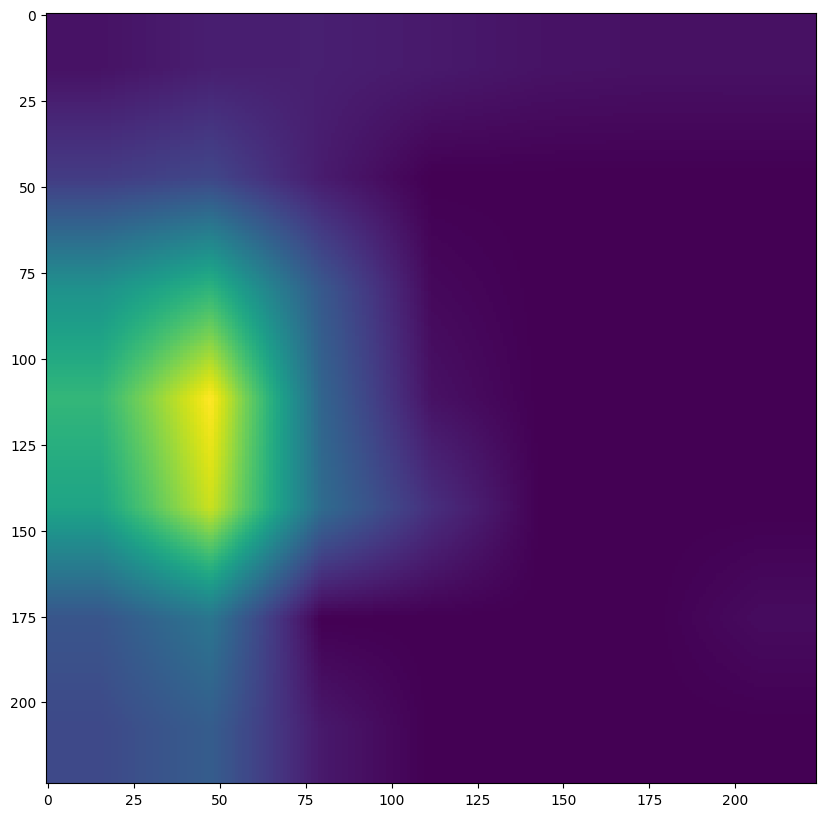

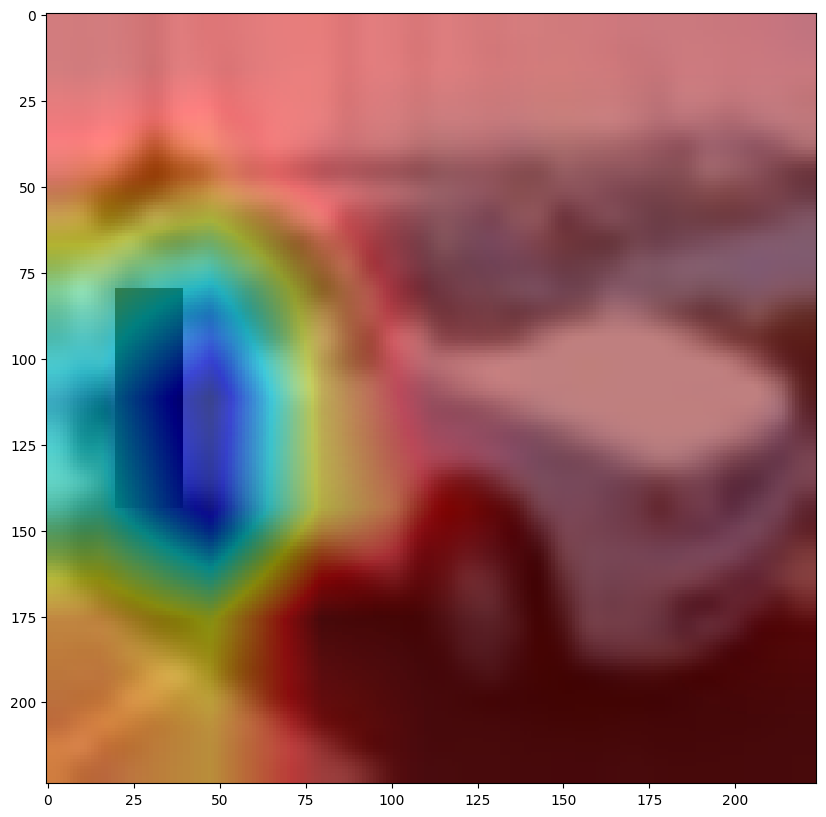

In [12]:
def displayImg(img):
    npImg = img
    plt.figure(figsize=(10,10))
    plt.imshow(npImg)
    plt.show()

displayImg(grayscale_cam)
displayImg(visualization)

In [13]:
gaussian_random_numbers = np.random.normal(loc=128, scale=127) 
print(gaussian_random_numbers)

65.12328937887673


In [14]:
#for i in range(0,len(visualization)):
#    for j in range(0,len(visualization)):
#        visualization[i,j,0] = np.random.normal(loc=128, scale=127) if visualization[i,j,0]>100 else visualization[i,j,0]

cv2.imwrite('./interpretation_GradCam/0.jpg',visualization)

True